# Lab 2b: Calculating daily temperature statistics and looking at extremes


In [2]:
## to use the landmask feature go to your terminal and type:
# conda activate yourenvironmentname
# conda install -c conda-forge regionmask

import numpy as np  # package for scientific computing---arrays, many basic calculations
import xarray as xr  # package for multi-dimensional arrays
import cartopy.crs as ccrs # to make maps
import cartopy.feature as cfeature
import matplotlib.pyplot as plt # plotting library
import scipy.stats
import glob
## import regionmask

%matplotlib inline

# function to convert temperature units
def convert_tas_units(dataarray):
    if units == 'C':
        return dataarray - 273.15
    elif units == 'K':
        return dataarray
    elif units == 'F':
        return (dataarray - 273.15) * 9/5 + 32

## Set up details of analysis

### Declare the root directory and names of the files you want to open

* Note 2 different time periods have been set up for these data: 
 * __hist__           (1850-2014) 
 * __ssp585__        (2015-2100)
 * the data put out by the different modeling centers comes in different time blocks so we have preprocessed it after download from the ESGF to have these time periods for simplicity. 
 * CMIP6 model projections are for SSP5-8.5 (Shared Socioeconomic Pathway for greenhouse gas and aerosol forcings)
 * CMIP5 model projections are for RCP 8.5 (Representative Concentration Pathway)
  * Note that the SSP starts later than the data for the RCP so the early century time periods don't match

### You can choose which model to analyze

Do this by changing model_index= to a value 0 through 5. Values 0 through 3 are CMIP6 models; 4, 5 are CMIP5 models.



In [3]:
%%time

# select the SSP scenario (ssp585 or ssp370)
ssp_scenario = 'ssp585'

# variable to load
var = 'tas'

# filepath for the CMIP6 data
filepath = f"/neelin2020/aos112/aos112_labs_current/aos112_lab2_data/{var}"

# list of model names to load dynamically
possible_model_names = [
    'BCC-CSM2-MR', 
    # 'CAMS-CSM1-0', 
    'CanESM5', 
#     'CESM2',
    'CESM2-WACCM',
#     'E3SM-1-1', 
    'GFDL-CM4', 
#     'GFDL-ESM4', 
#     'HadGEM3-GC31-LL',
#     'IPSL-CM6A-LR', 
    'MIROC6'
]

# dictionary to store datasets for each model
datasets = {}

# function to load a model's data for the selected SSP scenario
def load_model_data(model):
    try:
        # Use glob to find all matching files for the selected SSP scenario
        hist_files = glob.glob(f"{filepath}/hist/{var}_day_{model}_historical_*.nc")
        ssp_files = glob.glob(f"{filepath}/ssp585/{var}_day_{model}_{ssp_scenario}_*.nc")

        if hist_files and ssp_files:
            # Load and combine historical and SSP datasets along the time dimension
            hist_ds = xr.open_mfdataset(hist_files, combine='by_coords')
            ssp_ds = xr.open_mfdataset(ssp_files, combine='by_coords')
            combined_ds = xr.concat([hist_ds, ssp_ds], dim='time')
            datasets[model] = combined_ds
            print(f"Loaded and combined historical + {ssp_scenario} for {model}")

       # # If only SSP files exist, load them
       #  elif ssp_files:
       #      datasets[model] = xr.open_mfdataset(ssp_files, combine='by_coords')
       #      print(f"Loaded {ssp_scenario} for {model}")

       #  # If only historical files exist, load them
       #  elif hist_files:
       #      datasets[model] = xr.open_mfdataset(hist_files, combine='by_coords')
       #      print(f"Loaded historical data for {model}")

        else:
            print(f"No files found for {model} with historical and {ssp_scenario} data.")

    except Exception as e:
        print(f"Error loading {model}: {e}")

# Step 7: Load data for each model using the function
for model in possible_model_names:
    load_model_data(model)

print('List of models:', datasets.keys())
model_names = list(datasets.keys()) # actual models that got loaded in 

Loaded and combined historical + ssp585 for BCC-CSM2-MR
Loaded and combined historical + ssp585 for CanESM5


/home/jilliandessing/.conda/envs/aos112_24/lib/python3.11/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/jilliandessing/.conda/envs/aos112_24/lib/python3.11/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/jilliandessing/.conda/envs/aos112_24/lib/python3.11/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/jilliandessing/.conda/envs/aos112_24/lib/python3.11/site-packages/xarray/conventions.py:428: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/jilliandessing/.conda/envs/aos

Loaded and combined historical + ssp585 for CESM2-WACCM
Loaded and combined historical + ssp585 for GFDL-CM4
Loaded and combined historical + ssp585 for MIROC6
List of models: dict_keys(['BCC-CSM2-MR', 'CanESM5', 'CESM2-WACCM', 'GFDL-CM4', 'MIROC6'])
CPU times: user 5.72 s, sys: 1.12 s, total: 6.84 s
Wall time: 7.46 s


### Define the region and season to analyze (use one that's there, or create your own)
- you can check the map in the next cell to see if the boundaries are where you want, and adjust if needed
- give your region a mnemonic name for labels on plots later

In [5]:
## REGION OPTIONS (add your own if needed) - these are in dictionary format, it stores all the different region and season opetions 
region_dict = {'Global': [-90, 90, 0, 360], 
               'CONUS': [25, 50, 235, 295], # contiguous US
               'Europe': [35, 55, 0, 60], 
               'SE_Asia': [-15, 30, 90, 120],
               'Gulf' : [15, 40, 260, 295]
               # add other regions in the format: 'region_name': [lat_start, lat_end, lon_start, lon_end]
}

## SEASON OPTIONS (add your own if needed)
season_dict = {'Annual': np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11 ,12]),
               'DJF': np.array([12, 1, 2]),
               'MAM': np.array([3, 4, 5]),
               'JJA': np.array([6, 7, 8]),
               'SON': np.array([9, 10, 11]),
               'NDJF': np.array([11, 12, 1, 2]),
               'JJASON': np.array([6, 7, 8, 9, 10, 11])
               # add other seasons in the format: 'season_name': np.array([month1, month2, month3, ...])
               }

# SELECT REGION AND SEASON HERE
region = 'Gulf'
season = 'JJASON'

# SELECT TEMPERATURE UNITS
units = 'C' # 'C' for Celsius, 'K' for Kelvin, 'F' for Fahrenheit)


### Plot this latitude/longitude range to visualize it

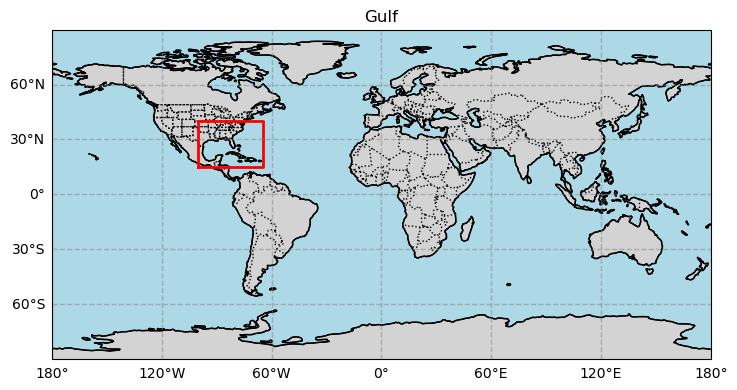

In [6]:
## Plots this latitude/longitude range to visualize it

fig = plt.figure(figsize=(8.5,11))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_global() # uncomment this to zoom in on the selected region
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, linestyle=':')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# add lat and lon ticks
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# plot 4 lines around these coordinates 

box_lon = [region_dict[region][2] - 360, region_dict[region][3] - 360, region_dict[region][3] - 360, region_dict[region][2] - 360, region_dict[region][2] - 360]
box_lat = [region_dict[region][0], region_dict[region][0], region_dict[region][1], region_dict[region][1], region_dict[region][0]]
ax.plot(box_lon, box_lat, color='red', linewidth=2, transform=ccrs.PlateCarree())


ax.set_title(region)
plt.show()


### Open the data here
- This cell takes a minute to run due to large data sets

In [10]:
# run this code so that the data gets subsetted to the region and season you selected
lat_start, lat_end, lon_start, lon_end = region_dict[region]
months = season_dict[season]

# subset CMIP6 data
datasets_subset = {}

for model in datasets.keys():
    # Select the region
    datasets_subset[model] = datasets[model].sel(lat=slice(lat_start, lat_end), lon=slice(lon_start, lon_end))
    
    # Select the season
    datasets_subset[model] = datasets_subset[model].sel(time=datasets_subset[model].time.dt.month.isin(months))

    # Convert temperature units
    datasets_subset[model]['tas'] = convert_tas_units(datasets_subset[model]['tas'])

### Get latitude and longitude values where the region is located

In [11]:
lon_lo, lon_hi, lat_lo, lat_hi = region_dict[region] # leftover variables from old code, needs to be streamlined

### Choose model and define the time periods to analyze


In [15]:
%%time
# this takes a few seconds to run 
## SELECT MODEL 
model_name = 'CESM2-WACCM'

#specify whether you want to use a land mask i.e., within your region only include land points
use_landmask = False

## SELECT TIME PERIOD HERE

# historical
hist_start   = 1900
hist_end     = 1999

# ssp 585
ssp_start   = 2000
ssp_end     = 2099

hist_years = str(hist_start) + '-' + str(hist_end)
ssp_years = str(ssp_start) + '-' + str(ssp_end)

# # # select the time period
model_hist_da = datasets_subset[model_name]['tas'].sel(time=slice(f'{hist_start}-01-01', f'{hist_end}-12-31'))
model_ssp_da = datasets_subset[model_name]['tas'].sel(time=slice(f'{ssp_start}-01-01', f'{ssp_end}-12-31'))

# landmask option
if use_landmask == True:
    land_mask = regionmask.defined_regions.natural_earth_v5_0_0.land_110
    land_only_mask_hist = land_mask.mask(model_hist_da, lon_name='lon', lat_name='lat')
    land_only_mask_ssp = land_mask.mask(model_ssp_da, lon_name='lon', lat_name='lat')

    model_hist_da = model_hist_da.where(land_only_mask_hist == 0)  # 0 indicates land regions
    model_ssp_da = model_ssp_da.where(land_only_mask_ssp == 0)  # 0 indicates land regions




model_hist = model_hist_da.to_numpy()
model_ssp = model_ssp_da.to_numpy()


CPU times: user 1min 1s, sys: 3.51 s, total: 1min 5s
Wall time: 46.4 s


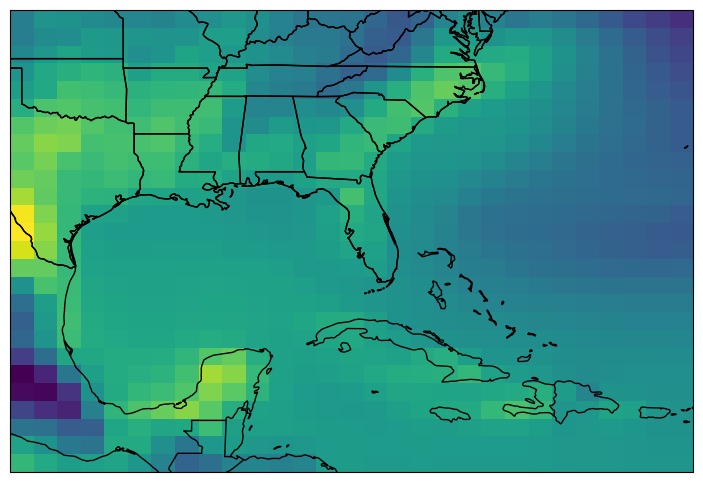

In [16]:
# plot the first timestep so you can see the extent of the landmask 

fig = plt.figure(figsize=(18, 6))
ax1 = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
# ax1.set_global() # this will zoom out to global view
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.BORDERS)


# plotting code - edit vmin, vmax, and cmap values if necessary 
plt.pcolormesh(model_hist_da.lon, 
                     model_hist_da.lat, 
                     model_hist_da[0], 
                     transform=ccrs.PlateCarree())


# ==================================================
# Histograms of daily surface air temperature
# ==================================================

### Calculate the means of the time periods for your region
 * Note that even though you start with daily data, this will be the mean over the season and decades that you chose, as well as over all grid points in the region you chose, so this is like the quantities computed in  Lab 1
 * Detail: the mean over the region is not an area-weighted average

In [17]:
hist_mean = np.mean(model_hist)
ssp_mean = np.mean(model_ssp)

# #values rounded to 2 decimal places
print(str(round(hist_mean,2))+' C'+' is the mean for historical')
print(str(round(ssp_mean,2))+' C'+' is the mean for ssp585')

25.44 C is the mean for historical
28.21 C is the mean for ssp585


### Compute your favorite percentile in each time period

In [18]:
perc_hi = 99. # 99th percentile
perc_lo = 1. # 1st percentile

value_hi_hist = scipy.stats.scoreatpercentile(model_hist, perc_hi)
value_lo_hist = scipy.stats.scoreatpercentile(model_hist, perc_lo)

value_hi_ssp = scipy.stats.scoreatpercentile(model_ssp, perc_hi)
value_lo_ssp = scipy.stats.scoreatpercentile(model_ssp, perc_lo)

### Print out these percentiles; how is the distribution changing?

In [19]:
print(str(round(value_hi_hist,2))+ units +' is the '+str(perc_hi)+'th percentile for historical')
print(str(round(value_hi_ssp,2))+units+' is the '+str(perc_hi)+'th percentile for ssp 8.5')
print()
print(str(round(value_lo_hist,2))+units+' is the '+str(perc_lo)+'th percentile for historical')
print(str(round(value_lo_ssp,2))+units+' is the '+str(perc_lo)+'th percentile for ssp 8.5')

33.28C is the 99.0th percentile for historical
37.23C is the 99.0th percentile for ssp 8.5

7.95C is the 1.0th percentile for historical
11.01C is the 1.0th percentile for ssp 8.5


### Define the bins and calculate the histograms

* Note that `density=True` means the resulting histogram will be a probability density function (frequency of occurrence normalized by total counts and by bin width).
* Setting `density=False` will give you the counts alone, and you can normalize this later as needed.
* default (bins=numpy.logspace...) uses bins that are constant in log(temperature) (i.e., they get wider for higher temperature). This helps to have enough  values per bin to have statistical significance at high temperature.
* can also reduce the number of bins to have more counts per bin 

In [20]:
Nbins= 100 #100  #sets the number of bins for the histogram
bin_lo= -50 #sets the lowest bin value
#  binning range set by the maximum value encountered times a factor slightly larger than one  e.g., 1.1 
bins = np.linspace(bin_lo,model_ssp.max(),Nbins) # linearly spaced bins
hist_histogram, bin_edges = np.histogram(model_hist, bins=bins, density=True)
ssp_histogram, bin_edges = np.histogram(model_ssp, bins=bins, density=True)

bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
bin_width = np.diff(bin_edges)

In [21]:
# min and max values of the data
model_hist.min(), model_hist.max(), model_ssp.min(), model_ssp.max()

(-10.292969, 41.492096, -5.9865417, 47.700348)

### Make histogram plots (linear y-scale)
 * with mean of the distribution shown on plot 

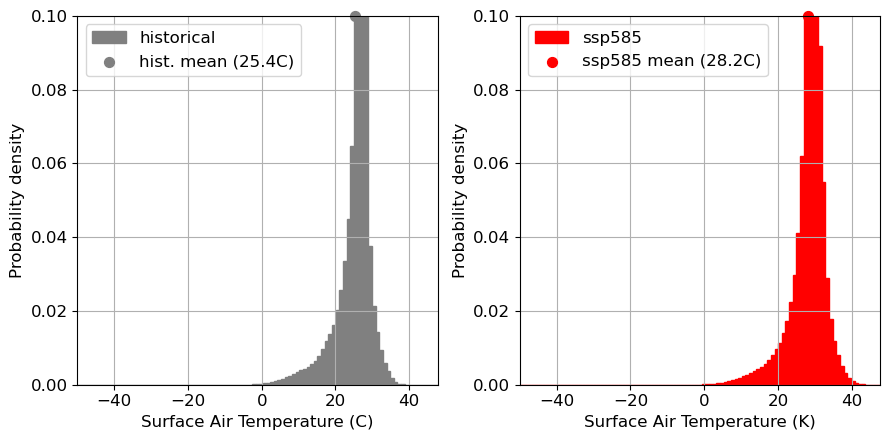

In [22]:
fig = plt.figure(figsize=(9,4.5))
fontsize=12
ymax=0.1 #sets the yscale for the figure; to zoom in y, change this value, e.g., ymax=.05

ax1 = fig.add_subplot(121)
ax1.bar(bin_centers, hist_histogram, align='center', width=bin_width, color='0.5', edgecolor='0.5', label='historical')
ax1.set_xlim(bins[0], bins[-1])  #only showing x-axis up to given value 
ax1.set_ylim(0, ymax)
ax1.tick_params(labelsize=fontsize)
ax1.set_ylabel('Probability density', fontsize=fontsize)
ax1.set_xlabel('Surface Air Temperature (' + units + ')' , fontsize=fontsize)
# ax1.set_title('Histogram for '+model+' ('+season+')'+'\n('+hist_years+')\n'+region+' ('+str(lat_lo)+'-'+str(lat_hi)+degree_sign+' lat. / '+str(lon_lo)+'-'+str(lon_hi)+degree_sign+' lon.)', fontsize=fontsize)
ax1.scatter(x=hist_mean, y=ymax, s=50, marker='o', clip_on=False, color='0.5', label='hist. mean ('+'{0:.1f}'.format(hist_mean)+ units+')')
ax1.grid()

handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[::-1], labels[::-1], loc=0, fontsize=fontsize)

ax2 = fig.add_subplot(122)
ax2.bar(bin_centers, ssp_histogram, align='center', width=bin_width, color='red', edgecolor='red', label='ssp585')
ax2.set_xlim(bins[0], bins[-1])
ax2.set_ylim(0, ymax)
ax2.tick_params(labelsize=fontsize)
ax2.set_ylabel('Probability density', fontsize=fontsize)
ax2.set_xlabel('Surface Air Temperature (K)', fontsize=fontsize)
# ax2.set_title('Histogram for '+model+' ('+season+')'+'\n('+ssp_years+')\n'+region+' ('+str(lat_lo)+'-'+str(lat_hi)+degree_sign+' lat. / '+str(lon_lo)+'-'+str(lon_hi)+degree_sign+' lon.)', fontsize=fontsize)
ax2.scatter(x=ssp_mean, y=ymax, s=50, marker='o', clip_on=False, c='red', label='ssp585' +' mean ('+'{0:.1f}'.format(ssp_mean)+ units+')')
ax2.grid()

handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles[::-1], labels[::-1], loc=0, fontsize=fontsize)

fig.tight_layout()

### Make combined, linear y-scale plot

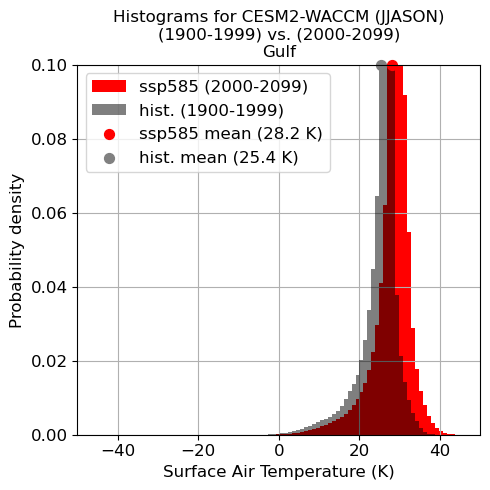

In [23]:
fig = plt.figure(figsize=(5,5))
fontsize=12
xmin=-50  # to zoom in x, change this value
xmax=50  # to zoom in x, change this value
ymax=0.1 #sets the yscale for the figure; to zoom in y, change this value, e.g., ymax=.05

ax = fig.add_subplot(111)
ax.bar(bin_centers, hist_histogram, align='center', width=bin_width, color='0', lw=0, label='hist. ('+hist_years+')', zorder=1, alpha=0.5)
ax.bar(bin_centers, ssp_histogram, align='center', width=bin_width, color='red', lw=0, label='ssp585' +' ('+ssp_years+')', zorder=0)
ax.set_xlim(xmin, xmax) 
ax.set_ylim(0, ymax)
ax.set_ylabel('Probability density', fontsize=fontsize)
ax.set_xlabel('Surface Air Temperature (K)', fontsize=fontsize)
ax.set_title('Histograms for '+model_name+' ('+season+')'+'\n('+hist_years+') vs. ('+ssp_years+')\n'+region, fontsize=fontsize)

# add means
ax.scatter(x=hist_mean, y=ymax, s=50, marker='o', clip_on=False, color='0.5', label='hist. mean ('+'{0:.1f}'.format(hist_mean)+' K)')
ax.scatter(x=ssp_mean, y=ymax, s=50, marker='o', clip_on=False, c='red', label='ssp585' +' mean ('+'{0:.1f}'.format(ssp_mean)+' K)')

ax.tick_params(labelsize=fontsize)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc=0, fontsize=fontsize)

ax.set_axisbelow(True)
ax.grid()
fig.tight_layout()

### Make histogram plots showing mean and high percentile with log y-axis option
* marks the mean value with a dot and your chosen high percentile value with a vertical line
* linear scale is shown if log_y_axis=False
* log y-scale plots are less useful for temperature than for precipitation unless you want to see really low probability events, or check if the distribution is close to Gaussian
* if you want to turn off a code cell change it to a non-code cell type (to turn it on/off, click in it and then choose Cell>cell type>code or raw).

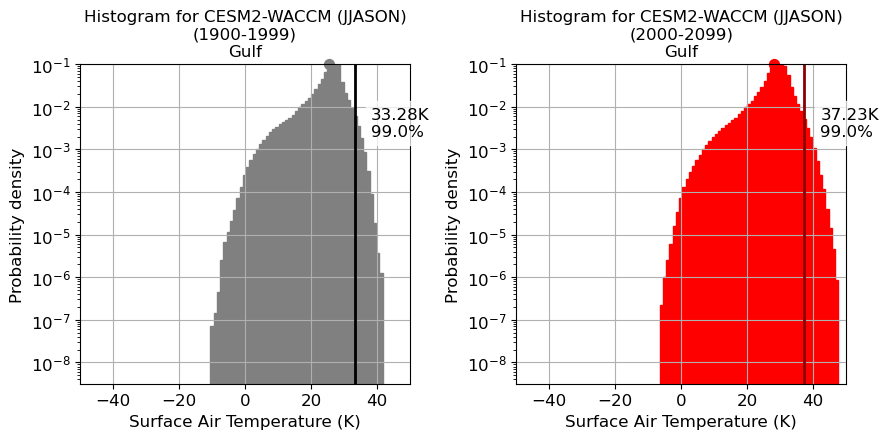

In [24]:
log_y_axis=True  #set this to False for a linear y-axis showing the high percentile
fig = plt.figure(figsize=(9,4.5))
fontsize=12
xmin=-50  # to zoom in x, change this value
xmax=50  # to zoom in x, change this value
ymax=0.1 #sets the yscale for the figure

ax1 = fig.add_subplot(121)
ax1.bar(bin_centers, hist_histogram, align='center', width=bin_width, color='0.5', edgecolor='0.5', label='historical')
ax1.set_xlim(xmin, xmax)
ax1.set_ylim(10**-8.5, ymax)
ax1.tick_params(labelsize=fontsize)
ax1.set_ylabel('Probability density', fontsize=fontsize)
ax1.set_xlabel('Surface Air Temperature (K)', fontsize=fontsize)
if log_y_axis:
    ax1.set_yscale('log')   #if uncommented, this sets the log y-scale (first subplot)
ax1.set_title('Histogram for '+model_name+' ('+season+')'+'\n('+hist_years+')\n'+region, fontsize=fontsize)
ax1.axvline(value_hi_hist, lw=2, c='0')
t=ax1.text(s='{:.2f}'.format(value_hi_hist)+'K\n'+str(perc_hi)+'%', ha='left', va='top', x=value_hi_hist+5, y=10**-2, fontsize=fontsize)
t.set_bbox(dict(color='1', alpha=0.75))
ax1.scatter(x=hist_mean, y=ymax, s=50, marker='o', clip_on=False, color='0.5', label='hist. mean ('+'{0:.1f}'.format(hist_mean)+' mm/day)')
ax1.grid()
#legend not showing so don't see labels

ax2 = fig.add_subplot(122)
ax2.bar(bin_centers, ssp_histogram, align='center', width=bin_width, color='red', edgecolor='red', label='ssp585')
ax2.set_xlim(xmin, xmax)
ax2.set_ylim(10**-8.5, ymax)
ax2.tick_params(labelsize=fontsize)
ax2.set_ylabel('Probability density', fontsize=fontsize)
ax2.set_xlabel('Surface Air Temperature (K)', fontsize=fontsize)
if log_y_axis:
    ax2.set_yscale('log')    #if uncommented, this sets log y-scale (second subplot)
ax2.set_title('Histogram for '+model_name+' ('+season+')'+'\n('+ssp_years+')\n'+region, fontsize=fontsize)
ax2.axvline(value_hi_ssp, lw=2, c='darkred')
t=ax2.text(s='{:.2f}'.format(value_hi_ssp)+'K\n'+str(perc_hi)+'%', ha='left', va='top', x=value_hi_ssp+5, y=10**-2, fontsize=fontsize)
t.set_bbox(dict(color='1', alpha=0.75))
ax2.scatter(x=ssp_mean, y=ymax, s=50, marker='o', clip_on=False, c='red', label='ssp585' +' mean ('+'{0:.1f}'.format(ssp_mean)+' mm/day)')
ax2.grid()

fig.tight_layout()

### Make combined histogram plot showing high percentile, with option for log y-scale 
 * marks the mean value with a dot and your chosen high percentile value with a vertical line
 * linear scale is shown if log_y_axis=False
 * log y-scale plots are less useful for temperature than precipitation unless you want to see really low probability events, or check if the distribution is close to Gaussian
 * A Gaussian distribution will look like an upside down parabola

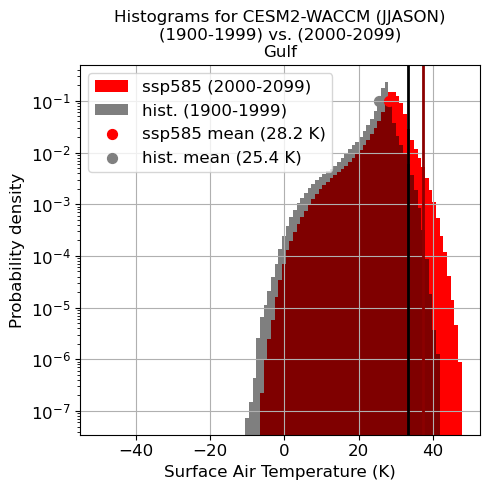

In [25]:
#log_y_axis=True  #value has been set above; on comment to set here. False for a linear y-axis 
fig = plt.figure(figsize=(5,5))
fontsize=12
xmin=240  # to zoom in x, change this value
xmax=325  # to zoom in x, change this value
ymax=0.1 #sets the yscale for the figure

ax = fig.add_subplot(111)
ax.bar(bin_centers, hist_histogram, align='center', width=bin_width, color='0', lw=0, label='hist. ('+hist_years+')', zorder=1, alpha=0.5)
ax.bar(bin_centers, ssp_histogram, align='center', width=bin_width, color='red', lw=0, label='ssp585' +' ('+ssp_years+')', zorder=0)
ax2.set_xlim(xmin, xmax)
ax2.set_ylim(10**-8.5, ymax)
ax.set_ylabel('Probability density', fontsize=fontsize)
ax.set_xlabel('Surface Air Temperature (K)', fontsize=fontsize)
ax.set_title('Histograms for '+model_name+' ('+season+')'+'\n('+hist_years+') vs. ('+ssp_years+')\n'+region, fontsize=fontsize)

ax.scatter(x=hist_mean, y=ymax, s=50, marker='o', clip_on=False, color='0.5', label='hist. mean ('+'{0:.1f}'.format(hist_mean)+' K)')
ax.scatter(x=ssp_mean, y=ymax, s=50, marker='o', clip_on=False, color='red', label='ssp585' +' mean ('+'{0:.1f}'.format(ssp_mean)+' K)')
ax.axvline(value_hi_hist, lw=2, c='0')
ax.axvline(value_hi_ssp, lw=2, c='darkred')

if log_y_axis:
    ax.set_yscale('log') # use log scale
ax.tick_params(labelsize=fontsize)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc=0, fontsize=fontsize)

ax.grid()
fig.tight_layout()

### Calculate the change of the mean of the distributions

In [26]:
print('Difference between mean for', 'ssp585','and historical =',str(round (ssp_mean-hist_mean, 2)), units)

Difference between mean for ssp585 and historical = 2.76 C


### Calculate how the value at a given historical percentile changes in the ssp 8.5 runs

In [27]:
perc_in_hist = perc_hi # set above, but change here if desired

# calculate the value (in degrees Celsius) that is at the 99th percentile
value_hist = scipy.stats.scoreatpercentile(model_hist, perc_in_hist)
print('HISTORICAL: ', '{:.1f}'.format(value_hist)+ units +' is the '+str(perc_in_hist)+'th percentile')

# now calculate how the probability of this event changes in ssp 8.5
perc_in_ssp = scipy.stats.percentileofscore(model_ssp.flatten(), value_hist)
print('FUTURE:     ', '{:.2f}'.format(perc_in_ssp)+'% is the percentile for this value in ', 'ssp585')

print()

# calculate the fractional increase in likelihood
fraction = (100-perc_in_ssp)/(100-perc_in_hist)
print('This temperature value has become '+'{:.2f}'.format(fraction)+' times as likely in', 'ssp585','relative to historical')

HISTORICAL:  33.3C is the 99.0th percentile
FUTURE:      93.52% is the percentile for this value in  ssp585

This temperature value has become 6.48 times as likely in ssp585 relative to historical


### Count the number of occurrences above this percentile value

* Approximate by counting events above this percentile value

In [28]:
print('HISTORICAL: ', np.sum(model_hist>=value_hist),'is the number of hot days above the',perc_in_hist,'th percentile of '+str(round(value_hist, 2)),units)
print('FUTURE:     ', np.sum(model_ssp>=value_hist),'is the number of hot days above the historical',perc_in_hist,'th percentile for', 'ssp585')
print()
print('{:.1f}'.format(np.sum(model_ssp>=value_hist)/np.sum(model_hist>=value_hist)),'is the ratio of ', 'ssp585',' to historical days above this threshold')

HISTORICAL:  137983 is the number of hot days above the 99.0 th percentile of 33.28 C
FUTURE:      893883 is the number of hot days above the historical 99.0 th percentile for ssp585

6.5 is the ratio of  ssp585  to historical days above this threshold


# ==================================================
# Extreme value calculations
# ==================================================

### Before we do any calculations, let's visualize what annual extremes look like

* Do this for the historical time period, from 1995 to 2000, for the middle lat/lon in the series

In [29]:
middle_lat = (lat_start + lat_end) / 2
middle_lon = (lon_start + lon_end) / 2

start = 1990
end = 1995

model_hist_ann_series = datasets_subset[model_name]['tas'].sel(time=slice(f'{start}-01-01', f'{end}-12-31')).sel(lat = middle_lat, lon = middle_lon, method='nearest') # select closest to midpoint 

# fix time issue
model_hist_ann_series['time'] = model_hist_ann_series.indexes['time'].to_datetimeindex()

/tmp/ipykernel_1656435/661686542.py:10: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  model_hist_ann_series['time'] = model_hist_ann_series.indexes['time'].to_datetimeindex()


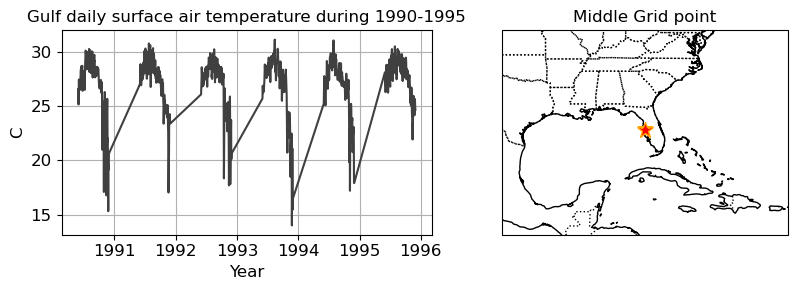

In [30]:
grid_lat = model_hist_ann_series.lat.values
grid_lon = model_hist_ann_series.lon.values

fontsize = 12
fig = plt.figure(figsize=(8.5,3))

ax1 = fig.add_subplot(121)
ax1.plot(model_hist_ann_series.time, model_hist_ann_series, c='0.25')
# ax1.scatter(model_hist_ann_max.year, model_hist_ann_max, color='firebrick', label='max annual\ntemp. values') # need to figure out how to plot annual maximum values 
ax1.tick_params(labelsize=fontsize)
ax1.set_title(region + ' daily surface air temperature during '+str(start)+'-'+str(end), fontsize=fontsize)
ax1.set_xlabel('Year', fontsize=fontsize)
ax1.set_ylabel(units, fontsize=fontsize)
ax1.grid()
# legend = ax1.legend(fontsize=fontsize)

# plot grid point on map
ax2 = fig.add_subplot(122, projection=ccrs.PlateCarree())
ax2.set_extent([region_dict[region][2], region_dict[region][3], region_dict[region][0], region_dict[region][1]], crs=ccrs.PlateCarree())
ax2.add_feature(cfeature.BORDERS, linestyle=':')
ax2.add_feature(cfeature.STATES, linestyle=':')
ax2.add_feature(cfeature.COASTLINE)
# ax2.set_global()
ax2.plot(grid_lon, grid_lat, marker='*', markerfacecolor = 'red', markeredgecolor = 'orange', markersize=12, transform=ccrs.PlateCarree())

ax2.set_title('Middle Grid point', fontsize=fontsize)

fig.tight_layout()

In [33]:
## subset time indices
## time_array_hist = time_variable_hist_converted[time_indices_hist]
## time_array_ssp = time_variable_ssp_converted[time_indices_ssp]

In [69]:
# middle_lat = round(model_hist_pr.shape[1]/2)
# middle_lon = round(model_hist_pr.shape[2]/2)

# start = 1990
# end = 1995 # must not go above 2001
# nyears = end-start

# # subset time between two years
# year_indices_time_span = [t.year in range(start, end) for t in time_array_hist]
# time_array_time_span = np.array(([dt.datetime(t.year,t.month,t.day) \
#                                      for t in time_array_hist[year_indices_time_span]]))
# model_hist_pr_time_span = model_hist_pr[year_indices_time_span, middle_lat, middle_lon]

# max_precip_time_span = []
# max_precip_time_span_dates = []

# for year_idx in range(nyears):
#     current_year = time_array_time_span[0].year+year_idx
#     year_indices = np.array([t.year==current_year for t in time_array_time_span]) # true when current year
#     max_precip_time_span.append(np.max(model_hist_pr_time_span[year_indices]))
#     max_idx = int(np.argmax(model_hist_pr_time_span[year_indices]))
#     max_precip_time_span_dates.append(time_array_time_span[year_indices][max_idx])

In [70]:
# fontsize = 12

# grid_lat = model_lat[model_lat_indices][middle_lat]
# grid_lon = model_lon[model_lon_indices][middle_lon]

# fig = plt.figure(figsize=(8.5,3))

# ax1 = fig.add_subplot(121)
# ax1.plot(time_array_time_span, model_hist_pr_time_span, c='0.25')
# ax1.scatter(max_precip_time_span_dates, max_precip_time_span, color='firebrick', label='max annual\ntemp. values')
# ax1.tick_params(labelsize=fontsize)
# ax1.set_title(region + ' daily surface air temperature during '+str(start)+'-'+str(end), fontsize=fontsize)
# ax1.set_xlabel('Year', fontsize=fontsize)
# ax1.set_ylabel('K', fontsize=fontsize)
# ax1.grid()
# legend = ax1.legend(fontsize=fontsize)

# # plot grid point on map
# ax2 = fig.add_subplot(122, projection=ccrs.PlateCarree())
# ax2.set_extent(region_dict[region], crs=ccrs.PlateCarree())
# ax2.add_feature(cfeature.BORDERS, linestyle=':')
# ax2.add_feature(cfeature.STATES, linestyle=':')
# ax2.add_feature(cfeature.COASTLINE)
# # ax2.set_global()
# ax2.plot(grid_lon, grid_lat, marker='*', markerfacecolor = 'red', markeredgecolor = 'orange', markersize=12, transform=ccrs.PlateCarree())

# ax2.set_title('Middle Grid point', fontsize=fontsize)

# fig.tight_layout()

In [37]:
# get annual max values for each year at each location

annual_max_hist_da = model_hist_da.groupby('time.year').max(dim='time')
annual_max_ssp_da = model_ssp_da.groupby('time.year').max(dim='time')

annual_max_hist = annual_max_hist_da.to_numpy()
annual_max_ssp = annual_max_ssp_da.to_numpy()


### Collect annual max values for historical temperature

In [72]:
# nyears_hist = time_array_hist[-1].year-time_array_hist[0].year+1
# nyears_ssp = time_array_ssp[-1].year-time_array_ssp[0].year+1
# #if obs:  nyears_obs = time_array_obs[-1].year-time_array_obs[0].year+1

# annual_max_hist_pr = np.zeros((nyears_hist, \
#                                   sum(model_lat_indices), \
#                                   sum(model_lon_indices)))

# annual_max_ssp_pr = np.zeros((nyears_ssp, \
#                                  sum(model_lat_indices), \
#                                  sum(model_lon_indices)))

# # loop through each year from the beginning to end of "time_array_hist"
# for year_idx in range(nyears_hist):
#     current_year = time_array_hist[0].year+year_idx
#     # get the correct indices of those days
#     year_indices = np.array([t.year==current_year for t in time_array_hist])
#     # for each lat/lon combo, loop through and get the max tas value
#     for lat_idx in range(sum(model_lat_indices)):
#         for lon_idx in range(sum(model_lon_indices)): 
#             annual_max_hist_pr[year_idx, lat_idx, lon_idx] = np.max(model_hist_pr[year_indices, lat_idx, lon_idx])
            
# # loop through each year from the beginning to end of "time_array_hist"
# for year_idx in range(nyears_ssp):
#     current_year = time_array_ssp[0].year+year_idx
#     # get the correct indices of those days
#     year_indices = np.array([t.year==current_year for t in time_array_ssp])
#     # for each lat/lon combo, loop through and get the max tas value
#     for lat_idx in range(sum(model_lat_indices)):
#         for lon_idx in range(sum(model_lon_indices)): 
#             annual_max_ssp_pr[year_idx, lat_idx, lon_idx] = np.max(model_ssp_pr[year_indices, lat_idx, lon_idx])

### Create extreme value distributions

In [73]:
bin_lo=-50 #sets the lowest bin value

#bins = numpy.logspace(-1,numpy.log10(max(model_ssp_pr.max(), model_hist_pr.max())),100) # log spaced bins
#bins = numpy.linspace(0,270,45) # linearly spaced bins set by hand
bins = np.linspace(bin_lo,(max(model_ssp.max(), model_hist.max()))*1.001,45) # linearly spaced bins
hist_histogram, bin_edges = np.histogram(annual_max_hist, bins=bins, density=True)
ssp_histogram, bin_edges = np.histogram(annual_max_ssp, bins=bins, density=True)

bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
bin_width = np.diff(bin_edges)

### Calculate magnitudes of return intervals

Edit **`return_period`** to change

In [38]:
#####################################################################################
########## CHANGE THE EVENT MAGNITUDE OR RETURN PERIOD YOU WANT TO INSPECT ##########
#####################################################################################
event_magnitude = 30 # C
return_period = 20 # specify the return period (i.e., an X-year event)
#####################################################################################
return_perc = 1-(1/return_period)

return_val_hist = scipy.stats.scoreatpercentile(annual_max_hist, return_perc*100)
return_val_ssp = scipy.stats.scoreatpercentile(annual_max_ssp, return_perc*100)

return_period_hist = 1/(1-scipy.stats.percentileofscore(annual_max_hist.flatten(), event_magnitude)/100.)
return_period_ssp = 1/(1-scipy.stats.percentileofscore(annual_max_ssp.flatten(), event_magnitude)/100.)

# print the magnitude of an X-year event
print('HISTORICAL:  The', \
      str(int(return_period))+'-year return value for daily extremes is about',\
      '{:.1f}'.format(return_val_hist),\
      units)
print('FUTURE:      The', \
      str(int(return_period))+'-year return value for daily extremes is about',\
      '{:.1f}'.format(return_val_ssp),\
      units)

print()

# print the return period of a given magnitude
print('HISTORICAL:  A', \
      str(event_magnitude)+units+' day has a return period of',\
      '{:.1f}'.format(return_period_hist),\
      'years')
print('FUTURE:      A', \
      str(event_magnitude)+units+' day has a return period of',\
      '{:.1f}'.format(return_period_ssp),\
      'years')

HISTORICAL:  The 20-year return value for daily extremes is about 36.1 C
FUTURE:      The 20-year return value for daily extremes is about 39.9 C

HISTORICAL:  A 30C day has a return period of 3.4 years
FUTURE:      A 30C day has a return period of 1.3 years


### From the  return period of events above the specified threshold, calculate risk ratio etc.
#### This is similar to what is used in probabilistic event attribution for an event of that size
- probability of exceedance of the threshold for historical and ssp, p_0 and p_1, are given by:
- p_0=1/return_period_hist ;  p_1=1/return_period_ssp
- Risk Ratio for SSP/Historical p_1/p_0
- Increased Risk (p_1/p_0 -1)
- Fraction of Attributable Risk (1-p_0/p_1)

In [39]:
print('For p_0 and p_1 the probability of exceeding', event_magnitude, units, 'in historical/ssp scenario')
print('The Risk Ratio for ssp585/Historical p_1/p_0 is a factor of', round(return_period_hist/return_period_ssp,3))
print('The Increased Risk (p_1/p_0 -1) as a percent=', round(return_period_hist/return_period_ssp-1.,3)*100.,'%')
print('The Fraction of Attributable Risk (1-p_0/p_1) as a percent=', round((1.-return_period_ssp/return_period_hist)*100.,2),'%')


For p_0 and p_1 the probability of exceeding 30 C in historical/ssp scenario
The Risk Ratio for ssp585/Historical p_1/p_0 is a factor of 2.512
The Increased Risk (p_1/p_0 -1) as a percent= 151.2 %
The Fraction of Attributable Risk (1-p_0/p_1) as a percent= 60.19 %


### Plot these results

The plots below include the N-year return period value calculated above as vertical lines

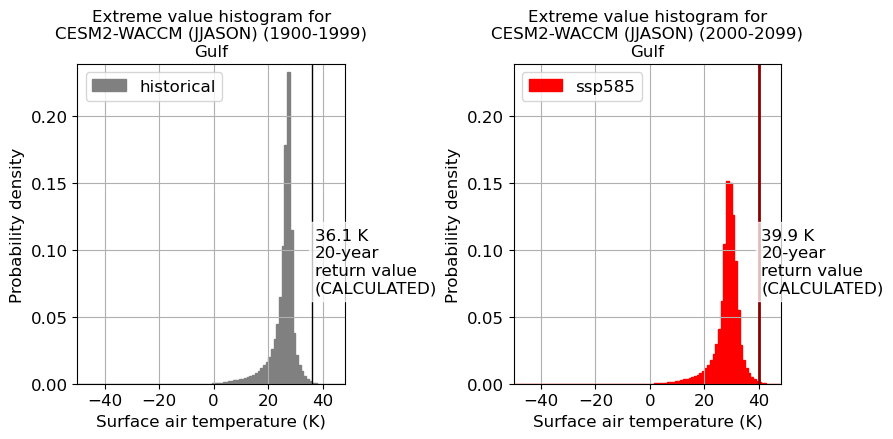

In [40]:
fig = plt.figure(figsize=(9,4.5))
fontsize=12

if return_period >30: t_offset = -5; horiz_align='right'
else:  t_offset = 1; horiz_align='left'

max_val = np.max([np.max(ssp_histogram), np.max(hist_histogram)])

ax1 = fig.add_subplot(121)
ax1.bar(bin_centers, hist_histogram, align='center', width=bin_width, color='0.5', edgecolor='0.5', label='historical')
ax1.set_xlim(bins[0], bins[-1]*1.01)
ax1.set_ylim(0, max_val*1.025)
ax1.tick_params(labelsize=fontsize)
ax1.set_ylabel('Probability density', fontsize=fontsize)
ax1.set_xlabel('Surface air temperature (K)', fontsize=fontsize)
ax1.set_title('Extreme value histogram for\n'+model_name+' ('+season+')'+' ('+hist_years+')\n'+region, fontsize=fontsize)
ax1.grid()
ax1.axvline(return_val_hist, lw=1, c='0')
t1=ax1.text(s='{:.1f}'.format(return_val_hist)+' K\n'+str(return_period)+'-year\nreturn value\n(CALCULATED)', \
           ha=horiz_align, va='top', x=return_val_hist+t_offset, y=max_val/2, fontsize=fontsize)
t1.set_bbox(dict(color='1', alpha=0.75))


handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[::-1], labels[::-1], loc=0, fontsize=fontsize)

ax2 = fig.add_subplot(122)
ax2.bar(bin_centers, ssp_histogram, align='center', width=bin_width, color='red', edgecolor='red', label='ssp585')
ax2.set_xlim(bins[0], bins[-1]*1.01)
ax2.set_ylim(0, max_val*1.025)
ax2.tick_params(labelsize=fontsize)
ax2.set_ylabel('Probability density', fontsize=fontsize)
ax2.set_xlabel('Surface air temperature (K)', fontsize=fontsize)
ax2.set_title('Extreme value histogram for\n'+model_name+' ('+season+')'+' ('+ssp_years+')\n'+region, fontsize=fontsize)
ax2.grid()
ax2.axvline(return_val_ssp, lw=2, c='darkred')
t1=ax2.text(s='{:.1f}'.format(return_val_ssp)+' K\n'+str(return_period)+'-year\nreturn value\n(CALCULATED)', \
           ha=horiz_align, va='top', x=return_val_ssp+t_offset, y=max_val/2, fontsize=fontsize)
t1.set_bbox(dict(color='1', alpha=0.75))

handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles[::-1], labels[::-1], loc=0, fontsize=fontsize)

fig.tight_layout()

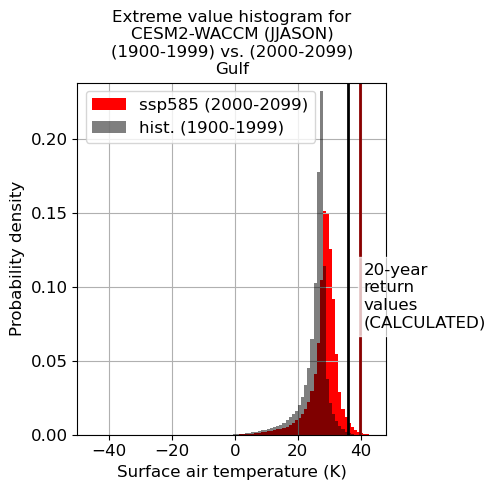

In [41]:
fig = plt.figure(figsize=(5,5))
fontsize=12

ax = fig.add_subplot(111)
ax.bar(bin_centers, hist_histogram, align='center', width=bin_width, color='0', lw=0, label='hist. ('+hist_years+')', zorder=1, alpha=0.5)
ax.bar(bin_centers, ssp_histogram, align='center', width=bin_width, color='red', lw=0, label='ssp585' +' ('+ssp_years+')', zorder=0, alpha=1)
ax.set_xlim(bins[0], bins[-1]*1.01)
ax.set_ylim(0, max_val*1.025)
ax.set_ylabel('Probability density', fontsize=fontsize)
ax.set_xlabel('Surface air temperature (K)', fontsize=fontsize)
ax.set_title('Extreme value histogram for\n'+model_name+' ('+season+')\n'+'('+hist_years+') vs. ('+ssp_years+')\n'+region, fontsize=fontsize)

ax.tick_params(labelsize=fontsize)

ax.axvline(return_val_hist, lw=2, c='0')
ax.axvline(return_val_ssp, lw=2, c='darkred')
t=ax.text(s=str(return_period)+'-year\nreturn\nvalues\n(CALCULATED)', \
           ha='left', va='top', x=max(return_val_hist,return_val_ssp)+1, y=max_val/2, fontsize=fontsize)
t.set_bbox(dict(color='1', alpha=0.75))

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc=0, fontsize=fontsize)

ax.grid()
ax.set_axisbelow(True)
fig.tight_layout()